In [1]:
import numpy as np
import pandas as pd
import bloscpack as bp

import imgaug as ia
import imgaug.augmenters as iaa

In [2]:
import fastai
from fastai.vision import *

from optim import Over9000

In [3]:
from torch.utils.data.dataloader import DataLoader
from data import DS_TRN

In [4]:
from model import *
from model_utils import *

---

In [5]:
SEED = 20190819

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

---
### data

In [ ]:
# stratified folds

In [6]:
sz = 128
bs = 128
nfolds = 4 #keep the same split as the initial dataset
fold = 0


TRAIN = '../features/grapheme-imgs-128x128/'
LABELS = '../input/train.csv'

In [70]:
a = data_bunch.one_batch()

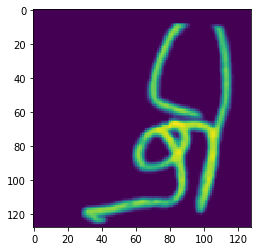

In [71]:
plt.imshow(a[0][0][0])

In [17]:
from PIL import Image

In [47]:
a = Image.open(os.path.join(TRAIN, df.iloc[0, 0] + '.png')).convert('L')

In [48]:
a = np.array(a)

In [53]:
a = a / 255

In [56]:
b = (a - 0.0692) / 0.2051

In [60]:
b.min()

-0.33739639200390054

In [46]:
?ImageList.from_df

Signature:
ImageList.from_df(
    df: pandas.core.frame.DataFrame,
    path: Union[pathlib.Path, str],
    cols: Union[int, Collection[int], str, Collection[str]] = 0,
    folder: Union[pathlib.Path, str] = None,
    suffix: str = '',
    **kwargs,
) -> 'ItemList'
Docstring: Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end.
File:      ~/miniconda3/envs/ML/lib/python3.7/site-packages/fastai/vision/data.py
Type:      method


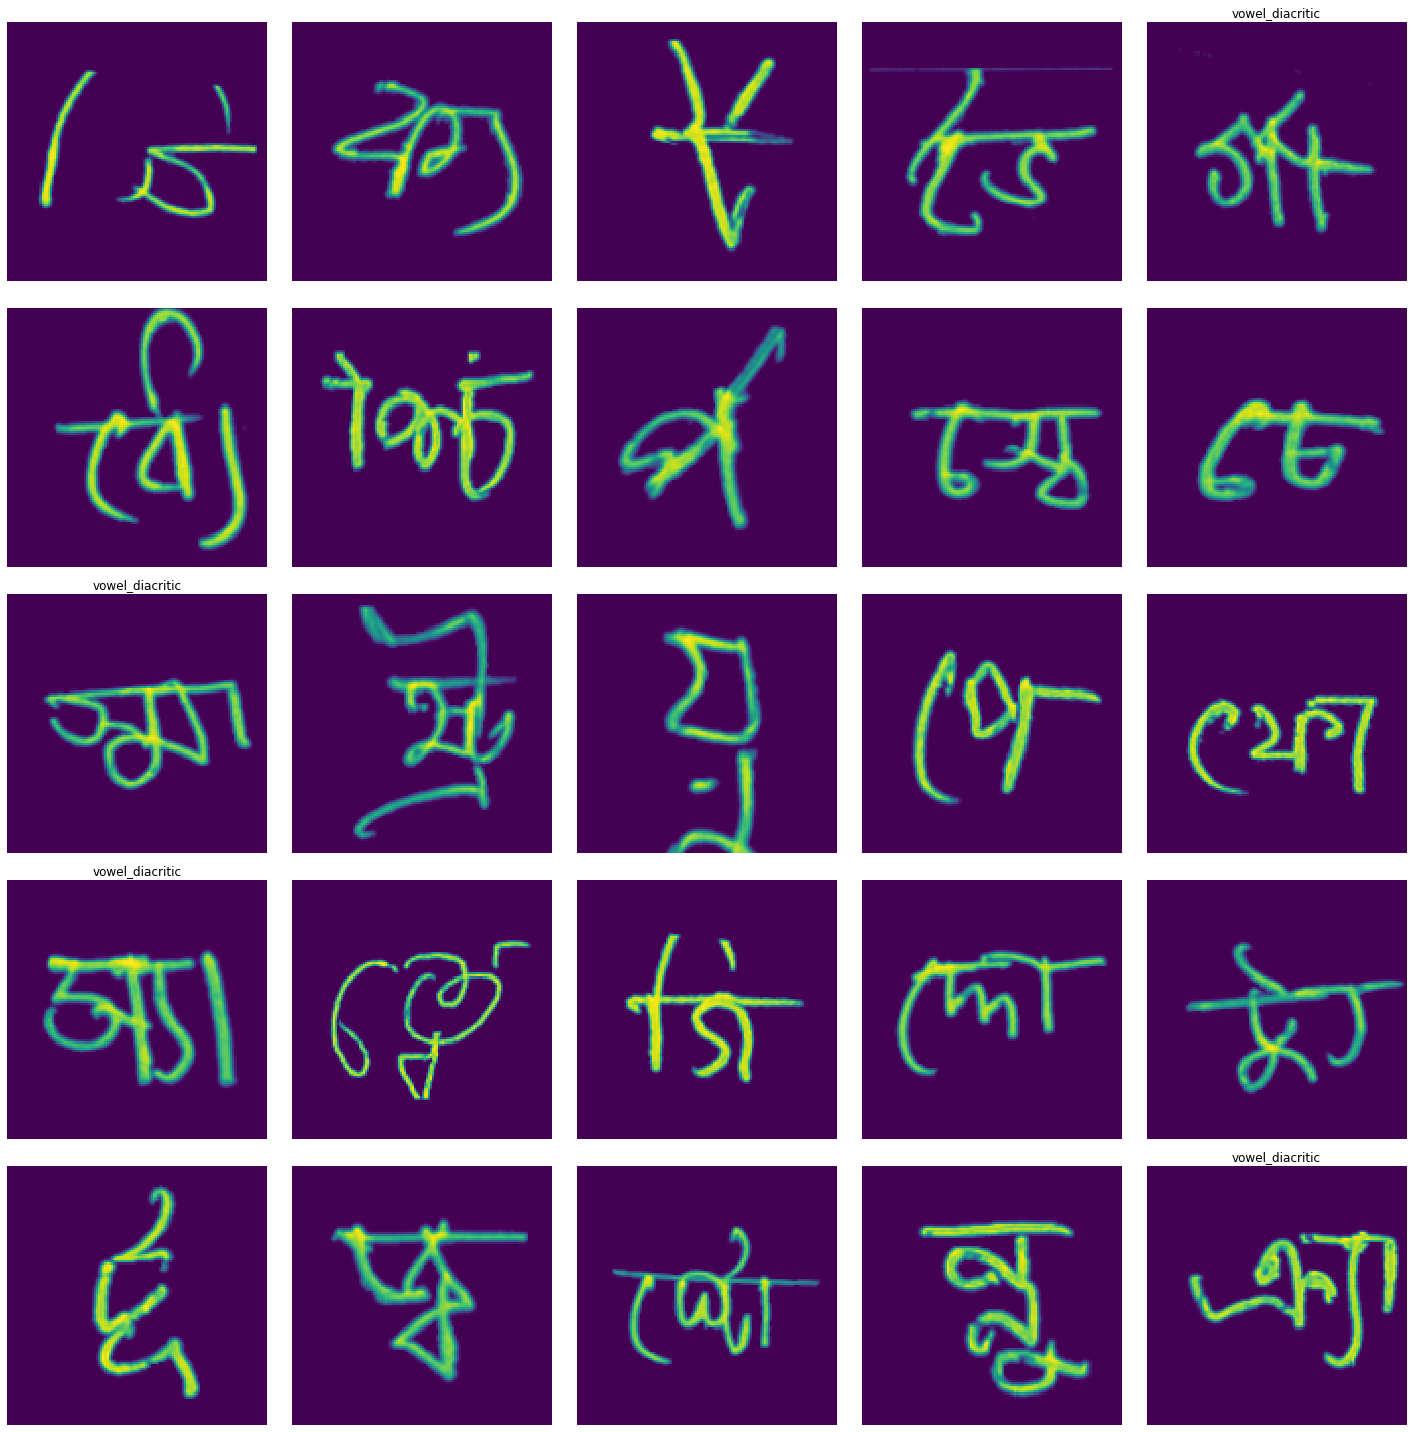

In [69]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]

stats = ([0.0692], [0.2051])
data_bunch = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id', convert_mode='L')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

data_bunch.show_batch()

---
### model

In [8]:
device = 'cuda:0'
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

In [9]:
predictor = PretrainedCNN(out_dim=n_total)
classifier = BengaliClassifier(predictor)#.to(device)

In [10]:
learn = Learner(
    data_bunch,
    classifier,
    loss_func=Loss_combine(),
    opt_func=Over9000,
    metrics=[Metric_grapheme(), Metric_vowel(), Metric_consonant(), Metric_tot()]
)

logger = CSVLogger(learn, 'Seresnext_DensenetStarterSetup_Myaugs')

learn.clip_grad = 1.0
learn.split([classifier.predictor.lin_layers])
# learn.split([classifier.head1])
learn.unfreeze()

In [11]:
learn.fit_one_cycle(
    32,
    max_lr=slice(0.2e-2,1e-2),
    wd=[1e-3, 0.1e-1],
    pct_start=0.0,
    div_factor=100,
    callbacks=[logger, SaveModelCallback(learn, monitor='metric_tot', mode='max', name='Seresnext_DensenetStarterSetup_Myaugs'), MixUpCallback(learn)] # 
)

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,1.297337,0.289646,0.896111,0.957423,0.951623,0.925317,11:00
1,1.141863,0.218834,0.920489,0.971873,0.962039,0.943722,10:58
2,1.055575,0.206644,0.926246,0.972548,0.966902,0.947985,10:59
3,0.960672,0.175331,0.939668,0.972731,0.973440,0.956377,10:55
4,0.896147,0.171044,0.941029,0.974166,0.973179,0.957351,11:00
5,0.840643,0.156052,0.944780,0.977232,0.969612,0.959101,10:55
6,0.795573,0.151328,0.946570,0.978327,0.972529,0.960999,10:59
7,0.746025,0.139468,0.952346,0.978899,0.978307,0.965475,10:58
8,0.706856,0.142623,0.952669,0.979642,0.973923,0.964725,10:56
9,0.654984,0.137251,0.955649,0.981015,0.977348,0.967415,11:00
